# Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

import os
import json

In [11]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [23]:
sns.set(style = 'whitegrid')

# Load data

In [12]:
data = pd.read_csv(os.path.join(data_path,'clean_data.csv'))
data.head()

,sampleNameOnTube,gender,treatment,tissue,injectionVolume,componentName,massInfo,componentGroupName,expectedRt,area,isArea,areaRatio,retentionTime,signalNoise,tissueWeightMg,normalizedArea,pnd,sampleName,isNormalizationFactor,normfactor
0,C20 M1 S,Male,Control,Striatum,10,SM(18:1)+H_d9_SPLASH.IS,738.7 / 184.2,SM,12.51,6.142877e+07,NaN,NaN,12.514791,141.426257,56,NaN,30,20,True,10
1,C20 M1 S,Male,Control,Striatum,10,SM(14:0)+H,675.5 / 184.1,SM,12.51,4.116176e+06,6.142877e+07,0.067007,12.737513,77.971430,56,0.119656,30,20,False,10
2,C20 M1 S,Male,Control,Striatum,10,SM(16:0)+H,703.6 / 184.1,SM,12.51,2.433723e+07,6.142877e+07,0.396186,12.662914,147.602022,56,0.707475,30,20,False,10
3,C20 M1 S,Male,Control,Striatum,10,SM(18:0)+H,731.6 / 184.1,SM,12.51,1.432478e+08,6.142877e+07,2.331933,12.580159,144.222304,56,4.164166,30,20,False,10
4,C20 M1 S,Male,Control,Striatum,10,SM(18:1)+H,729.6 / 184.1,SM,12.51,1.268323e+08,6.142877e+07,2.064706,12.572303,193.985512,56,3.686974,30,20,False,10


# Manipulate data

Extract log value of the target variable

In [13]:
columns_to_transform = ['areaRatio']

for c in columns_to_transform:
    data['log'+c[0].capitalize()+c[1:]] = data[c].apply(lambda x: np.log(x))

Drop NaN

In [14]:
print(f'Number of points before NaN removal: {data.shape[0]}')
data.dropna(axis=0, subset=['areaRatio'], inplace=True)
print(f'Number of after before NaN removal: {data.shape[0]}')

Number of points before NaN removal: 57264
Number of after before NaN removal: 31367


Drop normalization factors

In [15]:
data_normalized = data[data['isNormalizationFactor'] == False]
print(f'Number of points after dropping the normalization factors: {data_normalized.shape[0]}')

Number of points after dropping the normalization factors: 31367


# Figures

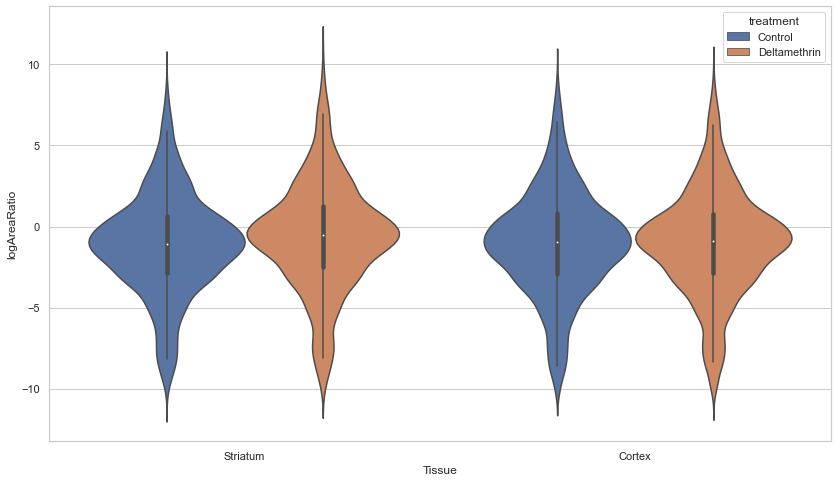

In [24]:
fig100 = plt.figure(figsize=(14,8))
ax = sns.violinplot(data=data, x='tissue', hue='treatment', y='logAreaRatio')
ax.set_xlabel('Tissue')

fig100.savefig("violinplot-tissue.svg", format='svg', facecolor='w')

plt.show()

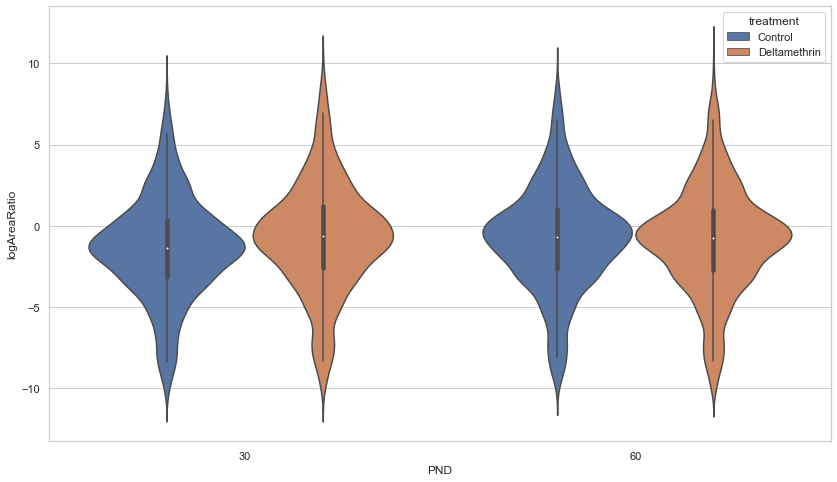

In [21]:
fig = plt.figure(figsize=(14,8))
ax = sns.violinplot(data=data, x='pnd', hue='treatment', y='logAreaRatio')
ax.set_xlabel('PND')
                    
fig.savefig("violinplot-pnd.svg", format='svg', facecolor='w')

plt.show()

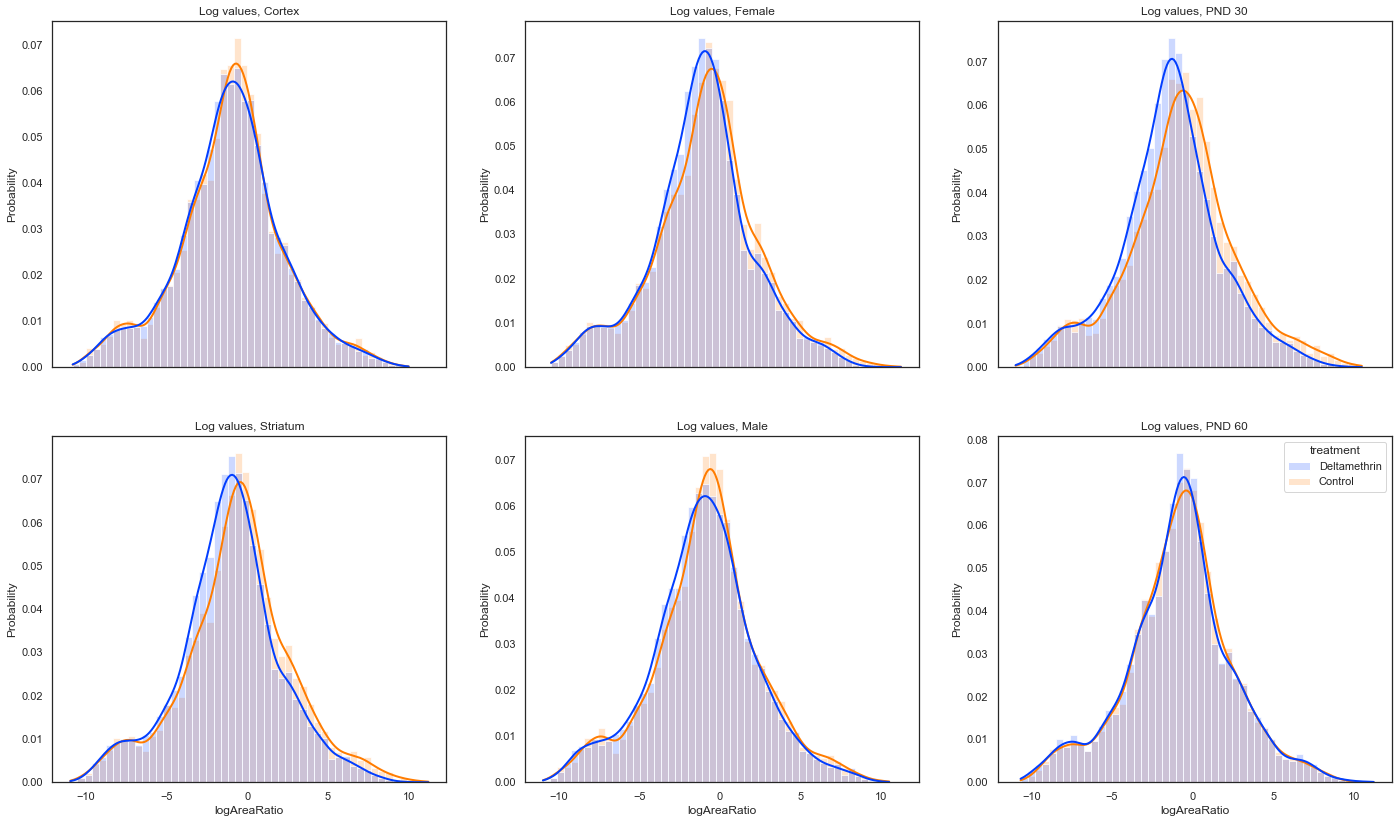

In [37]:
sns.set_style('white')

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[data['tissue'] == 'Cortex'], x='logAreaRatio', hue='treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Cortex')
sns.histplot(data=data[data['tissue'] == 'Striatum'], x='logAreaRatio', hue='treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum')

sns.histplot(data=data[data['gender'] == 'Female'], x='logAreaRatio', hue='treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Female')
sns.histplot(data=data[data['gender'] == 'Male'], x='logAreaRatio', hue='treatment', ax=ax[1,1], legend=False, **opt)
ax[1,1].set_title('Log values, Male')

sns.histplot(data=data[data['pnd'] == 30], x='logAreaRatio', hue='treatment', ax=ax[0,2], legend=False, **opt)
ax[0,2].set_title('Log values, PND 30')
sns.histplot(data=data[data['pnd'] == 60], x='logAreaRatio', hue='treatment', ax=ax[1,2], legend=True, **opt)
ax[1,2].set_title('Log values, PND 60')

fig.savefig('distribution-3cases.svg',format='svg',facecolor='w')

plt.show()

# Statistics

## Wilcoxon test applied on the data with no normalization

#### Data divided by tissue

In [38]:
tissue = ['Striatum','Cortex']
gender = ['Female', 'Male']
pnd = [30,60]
var_name = 'areaRatio'


for t in tissue:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['tissue']==t)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['tissue']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ranksums(a,b).pvalue:.2e}')

Tissue: Striatum. P-value: 2.38e-27
Tissue: Cortex. P-value: 1.99e-01


#### Data divided by gender

In [39]:
for g in gender:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['gender']==g)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['gender']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ranksums(a,b).pvalue:.2e}')

Gender: Female. P-value: 8.72e-14
Gender: Male. P-value: 3.26e-06


#### Data divided by PND

In [40]:
for p in pnd:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['pnd']==p)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['pnd']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 2.34e-38
PND: 60. P-value: 1.36e-01


## T-test applied on the data with log normalization

#### Data divided by tissue

In [41]:
var_name = 'logAreaRatio'

for t in tissue:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['tissue']==t)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['tissue']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Tissue: Striatum. P-value: 2.23e-22
Tissue: Cortex. P-value: 3.14e-01


#### Data divided by gender

In [42]:
for g in gender:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['gender']==g)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['gender']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Gender: Female. P-value: 5.85e-11
Gender: Male. P-value: 1.95e-05


#### Data divided by PND

In [43]:
for p in pnd:
    a = data_normalized[(data_normalized['treatment'] == 'Control') & (data_normalized['pnd']==p)][var_name]
    b = data_normalized[(data_normalized['treatment'] == 'Deltamethrin') & (data_normalized['pnd']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 2.34e-38
PND: 60. P-value: 1.36e-01


## Three-way ANOVA on log normalized data

#### Quelli singoli sono mediati su tutto ilmresto. a prescondere tra striato e corteccia la area ratio è diversa. Mentre l'effetto del secondo oridne dice che è vero che aprtono da livelli differenti diversi striato e corteccia, ma l'effetto del trattamento ha effetto anche se loro sono già diversi, mentr eil trattamento non ha effetto su maschi e donne

In [13]:
model = ols('logAreaRatio ~ C(gender) + C(treatment) + C(tissue) + C(gender):C(treatment) + C(tissue):C(treatment)', data=data_normalized).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(gender),6.627113,1.0,0.621733,4.304099e-01
C(treatment),622.522821,1.0,58.402983,2.196490e-14
C(tissue),191.664073,1.0,17.981274,2.237272e-05
C(gender):C(treatment),26.035955,1.0,2.442605,1.180901e-01
C(tissue):C(treatment),404.384124,1.0,37.937949,7.391703e-10
Residual,334279.814181,31361.0,NaN,NaN
